# Installation: Windows with Anaconda:

PyTorch does not support Python 2 on Windows.

A Python 3 `environment` has to be created first by
```
conda create -n py36 python=3.6 anaconda
```
After a lengthy installation, the environment is then deployed by
```
conda activate py36
```

The command for installing PyTorch is found [here](https://pytorch.org/get-started/locally/).  In my case where a GPU is not available, the PyTorch ecosystem is installed by,
```
conda install pytorch-cpu torchvision-cpu -c pytorch
```

The Python 3 installation might alter the default browser for the Jupyter Notebook.  To reset the browser, first fo the following in the command line,
```
jupyter notebook --generate-config
```
And next specify the path to the browser in the config file,
```
c.NotebookApp.browser = u'path_to_browser %s'
```
Note that `%s` has to be in the string.

# Background

Several modeling methods for sequential data [Hinton2013]:

Memoryless models: limited word-memory window; hidden state cannot be used efficiently.
1. Autoregressive models: Predict the next term in a sequence from a fixed number of previous terms using delay taps.
2. Feed-forward neural nets: Generalize autoregressive models by using one or more layers of non-linear hidden units.

Memoryful models: time-cost to infer the hidden state distribution.
1. Linear Dynamical Systems: Generative models with real-valued hidden states that cannot be observed directly.
2. Hidden Markov Models: Have a discrete one-of-N hidden state. Transitions between states are stochastic and controlled by a transition matrix. The outputs produced by a state are stochastic.

Finally, the RNN model: Update the hidden state in a deterministic nonlinear way.  Advantages:
1. Distributed hidden state that allows them to store a lot of information about the past efficiently.
2. Non-linear dynamics that allows them to update their hidden state in complicated ways.
3. No need to infer hidden state, pure deterministic.
4. Weight sharing.

# Theory
## Basics

From CS231N, 2017 Lecture 10

$h_t = f_W(h_{t-1}, x_t)$

$h$ is the (hidden) state, $x$ is the input, $f_W$ is an activation function with weights $W$.  The time steps $t$ and $t-1$ makes the formula recurrent.  $f_W$ and $W$ may be shared between different layers.  Note that all the quantities should be considered as vectors and matrices if not otherwise stated.

A vanilla RNN is
$$
\begin{array}{rl}
h_t &= \tanh(W_{hh}h_{t-1} + W_{xh}x_t) \\
y_t &= W_{hy}h_t
\end{array}
$$
where $y_t$ is the output.  It looks very much like a linear system, except that it has a nonlinear activation function.

There are multiple types of RNNs: one-to-one, one-to-many, many-to-one, many-to-many, etc.  In other words, the inputs $x_t$ and outputs $y_t$ are not necessarily nonzero.  For example, an RNN is many-to-one when all of its inputs are assumed to be nonzero and only one output is expected (e.g. at the end) - this could be the case for a sequence classification problem.

# Gradient problems

The training of an RNN requires a proper definition of the error, or the scalar loss function $E$,
$$
E = \sum_{t=1\ldots s} E_t(y_t, \bar{y}_t)
$$
where $s$ time steps are assumed, and $\bar{y}_t$ represent the ground truth.

The weights $W$ are computed by the gradient descent method, where the gradient is computed from the back propagation (BP) of the error.  In other words, one needs to obtain the derivative of $E$ w.r.t. $W$ via the chain rule,
$$
\frac{\partial E}{\partial W} = \sum_{t=1,\ldots,s} \frac{\partial E_t}{\partial W}
$$
where
$$
\frac{\partial E_t}{\partial W} = \frac{\partial E_t}{\partial y_t} \frac{\partial y_t}{\partial h_t} \frac{\partial h_t}{\partial W}
$$

Now, focus on the weights for $h$, i.e. $W_{hh}$, which will be written as $W$ for simplicity in the following.  There is a "double dependency" in the gradient $\frac{\partial h_t}{\partial W}$: (1) $h_t$ itself depends on all the past states; (2) a past state depends on the states prior to that state, too.  Mathematically,
$$\frac{\partial h_t}{\partial W} = \sum_{k=1,\ldots,t} \frac{\partial h_t}{\partial h_k} \frac{\partial h_k}{\partial W}$$
$$\frac{\partial h_t}{\partial h_k} = \prod_{i=k+1,\ldots,t} \frac{\partial h_i}{\partial h_{i-1}}$$
where
$$
\frac{\partial h_i}{\partial h_{i-1}} = \Lambda[f_W']W
$$

The issue in the BP of RNN comes from the product in $\frac{\partial h_t}{\partial h_k}$.  For each term of the product
$$
\left\lVert\frac{\partial h_t}{\partial h_k}\right\rVert \le \lVert\Lambda[f_W']\rVert \lVert W\rVert \le \gamma_f \gamma_W
$$
where $\gamma_f$ and $\gamma_W$ are the maximum singular values of $\Lambda[f_W']$ and $W$, respectively.  For the product
$$
\left\lVert\frac{\partial h_t}{\partial h_k}\right\rVert \le (\gamma_f \gamma_W)^{t-k}
$$

When $f_W$ is a function like $\tanh$, $\gamma_f$ would be close to zero as the input moves away from zero.  As for $W$, $\gamma_W$ is probably either $<1$ or $>1$.  Therefore, a sufficiently large $t-k$, i.e. time span of dependency, can cause two issues for the BP,
1. Vanishing gradients: $\left\lVert\frac{\partial h_t}{\partial h_k}\right\rVert \rightarrow 0$, making $\frac{\partial E_t}{\partial W}\sim 0$.  In other words, the past states cannot be practically involved in BP.
2. Exploding gradients: $\left\lVert\frac{\partial h_t}{\partial h_k}\right\rVert \gg 1$, making $\frac{\partial E_t}{\partial W}\gg 1$.  In other words, the BP may experience a computational overflow.

Another way to see the gradient problem is via the propagation of the variation/error of the hidden state $h$.  This way is somewhat hand-waving but more concise.  The error of $h_t$ is,
$$
\delta h_t = f_W' \odot (\delta W h_{t-1} + W \delta h_{t-1})
$$
where $\odot$ is element-wise vector product and the variation associated with the input is ignored.  The second term in the bracket represents the contribution of the error of the previous states to the error of the current state,
$$
\delta h_t \sim (f_W'\odot W)^k \delta h_{t-k}
$$
For situations discussed in the previous paragraph, the factor $(f_W'\odot W)^k$ can be (1) vanishing, so that $\delta h_{t-k}$ almost does not contribute to $\delta h_t$; (2) exploding, so that the contribution of $\delta h_{t-k}$ overwhelms the contributions of the other states.

The issue of vanishing and exploding gradients does not mean the RNN model is impractical, but rather means that the gradient descent becomes increasingly inefficient when the temporal span of the dependencies increases.

There are some fixes to circumvent the gradient issue while retaining the basic RNN structure,
1. For vanishing gradients, one can perform a proper initialization of the weights, and incorporate a more well-behaved activation function, such as the rectified linear unit (ReLU): $f(x)=\max(0,x)$
2. For exploding gradient, one can do a clipping trick with a threshold $T$ for the gradient $\nabla$,
$$
\nabla' = \frac{T}{\lVert\nabla\rVert^2}\nabla,\quad \mbox{if}\quad \lVert\nabla\rVert^2 > T
$$

# Long Short Term Memory

A more systematic solution to the vanishing gradient problem is the Long Short Term Memory (LSTM) model.  It introduces a "memory cell" that enables the storage and access of information over long periods of time.  The state equation for LSTM is now significantly expanded from the vanilla RNN,
$$
\begin{array}{rl}
i_t &= \mathrm{sigm}(W_{hi}h_{t-1} + W_{xi}x_t + b_i) \\
f_t &= \mathrm{sigm}(W_{hf}h_{t-1} + W_{xf}x_t + b_f) \\
o_t &= \mathrm{sigm}(W_{ho}h_{t-1} + W_{xo}x_t + b_o) \\
g_t &= \tanh(W_{hg}h_{t-1} + W_{xg}x_t + b_g) \\
c_t &= f_t \odot c_{t-1} + i_t \odot g_t \\
h_t &= o_t \odot \tanh(c_t)
\end{array}
$$
where $\mathrm{sigm}$ is the sigmoid function acting as a switch and $b$ is a constant offset vector.

In the LSTM model, the current hidden state is no longer directly related to the current input and the previous hidden state.  Rather, it is now an output from the memory cell $c_t$.  The memory cell is essentially a weighted sum of the past memory and the current information.  In other words, it determines: (1) whether to activate the information from past steps, and (2) whether to overwrite the memory with the information from the current step.  Specifically, three new gates are introduced, [Graves]
1. Input gate: Scale input to cell (write)
2. Output gate: Scale output from cell (read)
3. Forget gate: Scale old cell values (reset)

The effect of the gates is better seen via the variation approach w.r.t. the hidden states, the memory cells, and the weights $W_{hg}$.  Note that $W_{hg}$ corresponds to $W_{hh}$ in the vanilla version and will again be written as $W$ below for simplicity.  Also note that,
$$
\delta (x\odot y) = \delta x \odot y + x \odot \delta y
$$

The variations of $c_t$ and $h_t$ are,
$$
\begin{array}{rl}
\delta c_t &= f_t\odot\delta c_{t-1} + \overline{W}\delta h_{t-1} + i_t\odot\delta W h_{t-1} \\
\delta h_t &= \delta o_t \odot \tanh(c_t) + o_t \odot \tanh' \odot \delta c_t
\end{array}
$$
where $\overline{W}$ is a condensed term containing several weights, including $W_{hg}$.  Note that $W_{hg}$ only appears in the errors in the memory cell.  Now, $\delta h_t$ propagates into $\delta c_t$ but $\delta c_t$ does not necessarily propagate into $h_{t-1}$.  Instead, $\delta c_t$ may be directly passed to $\delta c_{t-1}$ without being affected by $W_{hg}$, thus avoiding the products of $W_{hg}$ and the gradient problems.

### SHELVED

In the LSTM version,
$$
\frac{\partial h_t}{\partial W} = \frac{\partial F_{oc}}{\partial o_t}\frac{\partial o_t}{\partial h_{t-1}}\frac{\partial h_{t-1}}{\partial W} + \frac{\partial F_{oc}}{\partial c_t}\frac{\partial c_t}{\partial W}
$$
where the notation $F_{xy}$ represents the product $x\odot y$.

There are several observations from the derivation above.  First, the gradient of $h_t$ now only depends on the gradient of the previous state $h_{t-1}$, and does not directly depend on the older states.  Furthermore, the gradient of $h_t$ is modulated by the gradient of the output $o_t$, i.e. the contribution of $\frac{\partial h_{t-1}}{\partial W}$ to $\frac{\partial h_t}{\partial W}$ may be eliminated if necessary.  Second, the gradient of $h_t$ now also depends on the gradient of the memory $c_t$, which encodes the gradient information of the previous states $h_{t-1}$ and $c_{t-1}$,
$$
C_t = A_{t-1} H_{t-1} + B_{t-1} C_{t-1} + D_t
$$
where
$$
C_t=\frac{\partial c_t}{\partial W},\quad H_t=\frac{\partial h_t}{\partial W},\quad A_{t-1}=\frac{\partial F_{fc}}{\partial f_t}\frac{\partial f_t}{\partial h_{t-1}} + \frac{\partial F_{ig}}{\partial h_{t-1}},\quad B_{t-1}=\frac{\partial F_{fc}}{\partial c_{t-1}},\quad D_t=\frac{\partial F_{ig}}{\partial g_t}\frac{\partial g_t}{\partial W}
$$
Recursively, one has,
$$
C_t = \Pi(B,k) C_{t-k} + \sum_{i=1...k} \Pi(B,i-1) (A_{t-i}H_{t-i} + D_{t-i+1}),\quad 1 \ll k < t
$$
where
$$
\Pi(B,k) = \prod_{j=1...k} B_{t-j}
$$
By properly choosing the weights in $A$ and $B$, one can retain the contribution of $H$ at a certain time step to $C_t$, while eliminating the contribution of the others.  In other words, a proper choice of weights in LSTM can make the gradient of $c_t$ equivalent to the gradient of a hidden state many time steps ago, and thus effectively propagating the gradient information of a past state into the gradient of the current state $h_t$.  This mechanism solves the vanishing gradient problem of the vanilla RNN from the root.

# Gated Recurrent Unit

A new type of RNN cell (Gated Feedback Recurrent Neural Networks) [Chung2015].  It is similar to LSTM, but computationally more efficient, as there are less parameters and less complex structure.

Mathematically, GRU is represented as,
$$
\begin{array}{rl}
r_t &= \mathrm{sigm}(W_{hr}h_{t-1} + W_{xr}x_t + b_r) \\
u_t &= \mathrm{sigm}(W_{hz}h_{t-1} + W_{xz}x_t + b_z) \\
g_t &= \tanh(W_{hg}(r_t\odot h_{t-1}) + W_{xg}x_t + b_g) \\
h_t &= u_t \odot h_{t-1} + (1-u_t) \odot g_t
\end{array}
$$

The GRU merges the cell state and hidden state, and thus $h$ replaces $c$ and the output gate $o_t$ is no longer needed.  Next, the GRU combines the forget and input gates into a single "update gate" $u_t$, which enables the inclusion of long-term behaviors in the RNN.  Finally, a reset gate $r_t$ is added to control the contribution of the previous states to the current prediction.

While many alternative LSTM architectures have been proposed, in Ref. [Greff2016], it was found that the vanilla LSTM performs reasonably well on various datasets and none of the eight investigated modifications (including GRU) significantly improves performance.  Furthermore, it was found that the forget gate and the output activation function as its most critical components.

https://danijar.com/tips-for-training-recurrent-neural-networks/
https://r2rt.com/non-zero-initial-states-for-recurrent-neural-networks.html

# References

1. Geoffrey Hinton, CSC2535 2013: Advanced Machine Learning, Lecture 10: Recurrent neural networks, University of Toronto.
1. Bengio et al, "Learning long-term dependencies with gradient descent is difficult", IEEE Transactions on Neural Networks, 1994.
1. Pascanu et al, "On the difficulty of training recurrent neural networks", ICML 2013.
1. Hochreiter and Schmidhuber, 1997.
1. Chung, Junyoung, et al. "Gated feedback recurrent neural networks." CoRR, abs/1502.02367 (2015).
1. Klaus Greff et al, "LSTM: A Search Space Odyssey", Transactions on Neural Networks and Learning Systems, 2016.

# Practice

The following code is adapted from [here](https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/403_RNN_regressor.py#L32)

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

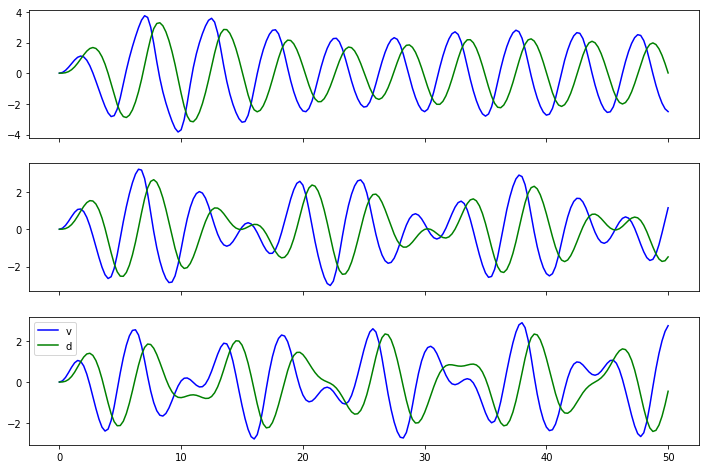

In [2]:
mu = 0.1
A  = 1.2
y0 = [0.0, 0.0]
t  = np.linspace(0, 50, 201)
steps = np.array(t, dtype=np.float32)

def vdp(y, t, mu, A, om):
    v, d = y
    f = mu*(1-d*d)*v - d
    return [f + A*np.sin(om*t), v]

def genData(om):
    sol = odeint(vdp, y0, t, args=(mu, A, om))
    return [
        np.array(A*np.sin(om*t), dtype=np.float32),
        np.array(sol, dtype=np.float32)
    ]

data = [genData(0.1*(_i+1)*np.pi) for _i in range(10)]
test = [genData(0.1*(_i+1.5)*np.pi) for _i in range(10)]

f, ax = plt.subplots(nrows=3, sharex=True, figsize=(12, 8))
for _i, _d in enumerate([data[3], test[3], data[4]]):
    ax[_i].plot(t, _d[1][:,0], 'b', label='v')
    ax[_i].plot(t, _d[1][:,1], 'g', label='d')
plt.legend(loc='best')

In [3]:
class RNN(nn.Module):
    def __init__(self, model, num_h, act_fun=None):
        super(RNN, self).__init__()

        _opts = {
            'input_size'  : 1,
            'hidden_size' : num_h,    # Number of hidden states
            'num_layers'  : 1,
            'batch_first' : True
        }
        if model == 'rnn':
            _m = nn.RNN
            _opts.update(nonlinearity = act_fun)   # Activation function: 'tanh' or 'relu'
        elif model == 'lstm':
            _m = nn.LSTM
        else:
            _m = nn.GRU

        self.rnn = _m(**_opts)
        self.out = nn.Linear(num_h, 2)  # Two output states

    def forward(self, x, h_state):
        r_out, _ = self.rnn(x, h_state)

        # General approach: Compute output step by step
        #outs = []
        #for time_step in range(r_out.size(1)):
        #    outs.append(self.out(r_out[:, time_step, :]))
        #return torch.stack(outs, dim=2), h_state

        return self.out(r_out)

In [8]:
def train_rnn(model, niter, index, learn):
    _optm = torch.optim.Adam(model.parameters(), lr=learn)
    _loss = nn.MSELoss()

    print("\nTraining starts")
    _h = []
    for _step in range(niter):
        _i, _j = index(_step)

        _xn, _yn = data[_i]
        _x = torch.from_numpy(_xn[np.newaxis, :_j, np.newaxis])
        _y = torch.from_numpy(_yn[np.newaxis, :_j, :])

        # Run from initial conditions by setting h_state=None
        _yp = model(_x, None)

        _l = _loss(_yp, _y)
        _h.append(_l.item())

        _t = _step+1
        if _t%100 == 0:
            print('{0:05d}, {1:5.4e}'.format(_t, _l.item()), end='; ')
        if _t%600 == 0:
            print()

        # Clear gradients, back-propagate, and optimize
        _optm.zero_grad()
        _l.backward()
        _optm.step()
    return np.array(_h)

def test_rnn(model, refs):
    _n = len(refs)

    f, ax = plt.subplots(nrows=_n, sharex=True, figsize=(12, 2+2*_n))
    for _i, _r in enumerate(refs):
        _x  = torch.from_numpy(_r[0][np.newaxis, :, np.newaxis])
        _yr = model(_x, None)
        _y  = _yr.data.numpy()[0]

        ax[_i].plot(steps, _r[1][:,0], 'r-')
        ax[_i].plot(steps, _y[:,0],   'r--')
        ax[_i].plot(steps, _r[1][:,1], 'b-')
        ax[_i].plot(steps, _y[:,1],   'b--')
    
    return f, ax

In [5]:
def fidx(step):
    return np.random.randint(2, 6), np.random.randint(40, 121)

m1 = RNN('rnn', 32, 'tanh')
m2 = RNN('rnn', 32, 'relu')
m3 = RNN('lstm', 32)
m4 = RNN('gru', 32)

for _i, _m in enumerate([m1, m2, m3, m4]):
    hst = train_rnn(_m, 10000, fidx, 0.01)

    f = plt.figure()
    plt.semilogy(hst)
    f.savefig('pics/m{0}_hist.png'.format(_i))
    plt.close()

    f, ax = test_rnn(_m, [test[2], data[3], test[3], data[4], test[4]])
    f.savefig('pics/m{0}_pred.png'.format(_i))
    plt.close()

print("\nDone!")


Training starts
00100, 1.5207e+00; 00200, 8.3343e-01; 00300, 9.2271e-01; 00400, 5.4432e+00; 00500, 1.1997e+00; 00600, 2.7089e+00; 
00700, 7.5472e-01; 00800, 2.8760e+00; 00900, 2.9496e+00; 01000, 1.6494e+00; 01100, 9.1217e-01; 01200, 8.1206e-01; 
01300, 9.0872e-01; 01400, 1.6744e+00; 01500, 5.8358e-01; 01600, 1.4325e+00; 01700, 3.9796e+00; 01800, 2.9823e-01; 
01900, 5.1824e-01; 02000, 1.3980e+00; 02100, 1.0711e+00; 02200, 1.7203e+00; 02300, 7.7242e-01; 02400, 9.9536e-01; 
02500, 1.6152e+00; 02600, 1.5804e+00; 02700, 2.0521e+00; 02800, 2.3338e+00; 02900, 1.6748e+00; 03000, 1.0782e+00; 
03100, 2.9268e+00; 03200, 1.2440e+00; 03300, 1.9037e+00; 03400, 1.6802e+00; 03500, 3.6841e+00; 03600, 9.6662e-01; 
03700, 1.5312e+00; 03800, 1.0726e+00; 03900, 1.5451e+00; 04000, 7.8454e-01; 04100, 2.7918e+00; 04200, 1.1024e+00; 
04300, 1.7778e+00; 04400, 1.8134e+00; 04500, 4.6837e+00; 04600, 3.0324e+00; 04700, 8.8643e-01; 04800, 1.1276e+00; 
04900, 1.4351e+00; 05000, 2.4353e+00; 05100, 3.9742e+00; 05200,

In [14]:
for _i, _m in enumerate([m1, m2, m3, m4]):
    f, ax = test_rnn(_m, [test[2], data[3], test[3], data[4], test[4]])
    for _j in range(5):
        ax[_j].set_title(r"$\omega={0:3.2f}\pi$".format(_j*0.05+0.35))
    f.savefig('pics/m{0}_pred.png'.format(_i))
    plt.close()